<a href="https://colab.research.google.com/github/BessieXuOrange/Data-Analysis/blob/main/Client_Analytics_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Teacher Certification — Analysis & Automation (Submission)

This notebook answers Section 1 and automates Section 2. See assumptions inside.

In [19]:
print('Notebook scaffold ok')

Notebook scaffold ok


In [20]:
from google.colab import files
uploaded = files.upload()

Saving Client Analytics Analysis Exercise Data.xlsx to Client Analytics Analysis Exercise Data (1).xlsx



## Assumptions & Definitions
- Use `training_year` and `board_cert_year` (renamed `certification_year`).
- No recertification fields → recert metrics set to 0, documented by design.
- `teacher_id` treated as **string** to avoid scientific notation / float precision issues.


In [21]:
import os, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [22]:
import io
# Load the entire Excel file
DATA_XLSX = 'Client Analytics Analysis Exercise Data.xlsx'

# Load the Excel file to access multiple sheets
excel_data = pd.ExcelFile(DATA_XLSX)

pd.set_option('display.float_format', '{:.0f}'.format)
%matplotlib inline


In [24]:
# Read specific sheets by their names
bg = excel_data.parse(sheet_name='background').rename(columns={"board_cert_year":"certification_year"})
perf = excel_data.parse(sheet_name='performance_evaluations')

if "teacher_id" not in perf.columns and "Unnamed: 0" in perf.columns:
    perf = perf.rename(columns={"Unnamed: 0": "teacher_id"})

bg["teacher_id"] = bg["teacher_id"].astype(str)
perf["teacher_id"] = perf["teacher_id"].astype(str)

for col in ["training_year", "certification_year"]:
    bg[col] = pd.to_numeric(bg[col], errors="coerce")

bg.head(3)


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,teacher_id,training_year,certification_year
0,10000831640,1970,1970
1,10001811121,1970,1970
2,10002674776,1970,1970


In [25]:

num_cols = perf.select_dtypes(include=[np.number]).columns.tolist()
metric_cols = [c for c in num_cols if c not in ["evaluation_year"]]

perf["perf_score"] = perf[metric_cols].mean(axis=1)
perf_summary = perf[["teacher_id", "evaluation_year", "perf_score"]].copy()
perf_summary.head(3)


,teacher_id,evaluation_year,perf_score
0,teacher_id,1971,1987
1,10000831640,46,46
2,10001811121,50,83


## Section 1 — Q1: First‑Try vs Retake (Pre‑1990)

In [26]:

bg["first_try_pass"] = (bg["certification_year"] == bg["training_year"])
bg_pre1990 = bg[bg["certification_year"] < 1990].copy()

merged = bg_pre1990.merge(perf_summary, on="teacher_id", how="left")
merged = merged[(merged["evaluation_year"].isna()) | (merged["evaluation_year"] >= merged["certification_year"])]

q1_stats = merged.groupby("first_try_pass")["perf_score"].agg(["count","mean","median","std"]).reset_index()
q1_stats


,first_try_pass,count,mean,median,std
0,False,537,60,59,18
1,True,8964,69,71,16


In [27]:

grp_true = merged.loc[merged["first_try_pass"] == True, "perf_score"].dropna()
grp_false = merged.loc[merged["first_try_pass"] == False, "perf_score"].dropna()

def welch_ttest(a, b):
    n1, n2 = len(a), len(b)
    m1, m2 = a.mean(), b.mean()
    v1, v2 = a.var(ddof=1), b.var(ddof=1)
    t = (m1 - m2) / math.sqrt(v1/n1 + v2/n2) if n1>1 and n2>1 else np.nan
    df = (v1/n1 + v2/n2)**2 / ((v1**2)/((n1**2)*(n1-1)) + (v2**2)/((n2**2)*(n2-1))) if n1>1 and n2>1 else np.nan
    try:
        from scipy import stats as sps
        p = 2 * sps.t.sf(abs(t), df)
    except Exception:
        p = None
    return {"n1": n1, "n2": n2, "mean1": float(m1), "mean2": float(m2), "t": float(t), "df": float(df), "p_two_sided": (None if p is None else float(p))}

q1_test = welch_ttest(grp_true, grp_false)
q1_stats, q1_test


(   first_try_pass  count  mean  median  std
 0           False    537    60      59   18
 1            True   8964    69      71   16,
 {'n1': 8964,
  'n2': 537,
  'mean1': 69.3826187740432,
  'mean2': 59.75019988927145,
  't': 12.191585848204442,
  'df': 591.7479452477472,
  'p_two_sided': 1.1672963427608798e-30})

## Section 1 — Q2: Pre‑ vs Post‑1990

In [28]:

bg["period"] = np.where(bg["certification_year"] < 1990, "pre_1990", "post_1990")

first_try_rate = (bg.groupby("period")["first_try_pass"].mean().reset_index(name="first_try_pass_rate"))
retake_rate = (bg.assign(retake=(bg["certification_year"] > bg["training_year"])).groupby("period")["retake"].mean().reset_index(name="retake_rate"))
avg_perf = bg.merge(perf_summary, on="teacher_id", how="left").groupby("period")["perf_score"].mean().reset_index(name="avg_perf_score")

q2_summary = first_try_rate.merge(retake_rate, on="period").merge(avg_perf, on="period")
q2_summary


,period,first_try_pass_rate,retake_rate,avg_perf_score
0,post_1990,1,0,69
1,pre_1990,1,0,69


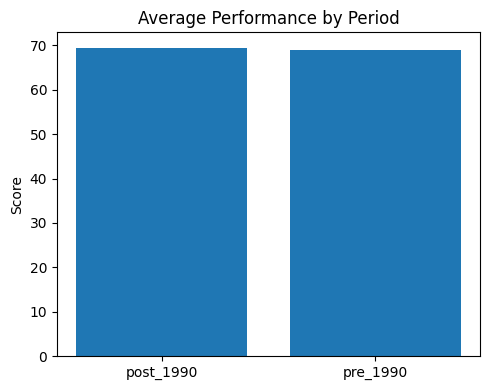

In [29]:
plt.figure(figsize=(5,4))
plt.bar(q2_summary["period"], q2_summary["avg_perf_score"])
plt.title("Average Performance by Period")
plt.ylabel("Score")

# save the picture
plt.tight_layout()
plt.savefig("D:\\求职——US\\公司\\Included Health\\fig_avg_perf.png", dpi=300)
plt.show()

## Section 2 — Annual Report Automation

In [31]:

def build_annual_report(df_bg, start=1970, end=2002):
    rows = []
    for y in range(start, end+1):
        trained_cnt = int((df_bg["training_year"] == y).sum())
        trained_pass = int(((df_bg["training_year"] == y) & (df_bg["certification_year"] == y)).sum())
        trained_fail = trained_cnt - trained_pass

        retake_pass = int(((df_bg["training_year"] < y) & (df_bg["certification_year"] == y)).sum())
        retake_not_pass = int(((df_bg["training_year"] < y) & (df_bg["certification_year"] > y)).sum())
        retake_total = retake_pass + retake_not_pass

        rows.append({
            "Year": y,
            "# of teachers who trained": trained_cnt,
            "# of teachers who trained and passed initial certification": trained_pass,
            "# of teachers who trained and did not pass initial certification": trained_fail,
            "# of teachers who retook initial certification": retake_total,
            "# of teachers who retook initial certification and passed": retake_pass,
            "# of teachers who retook initial certification and did not pass": retake_not_pass,
            "# of teachers who were up for recertification": 0,
            "# of teachers who passed recertification": 0,
            "# of teachers who failed recertification": 0,
        })
    return pd.DataFrame(rows)

annual_report = build_annual_report(bg, 1970, 2002)
annual_report.to_excel(r"D:\\求职——US\\公司\\Included Health\annual_report_template_filled.xlsx", index=False)
annual_report.head()


,Year,# of teachers who trained,# of teachers who trained and passed initial certification,# of teachers who trained and did not pass initial certification,# of teachers who retook initial certification,# of teachers who retook initial certification and passed,# of teachers who retook initial certification and did not pass,# of teachers who were up for recertification,# of teachers who passed recertification,# of teachers who failed recertification
0,1970,500,465,35,0,0,0,0,0,0
1,1971,500,474,26,35,33,2,0,0,0
2,1972,500,468,32,28,27,1,0,0,0
3,1973,500,475,25,33,32,1,0,0,0
4,1974,500,473,27,26,26,0,0,0,0
